In [1]:
import tables
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
import importlib as il

import sys
sys.path.append("../0nubbdata_LXe_Analysis/src/")

import clustering_fun as cf
import plotter as pl
import analysis_functions as af
import selector as sl
import MC_topology as MCtp

sys.path.append("../../NEXT/ASpirit/src/")

import Topology_functions as tf
import plot_functions as plf

In [370]:
file = tables.open_file("data/GXe_0nubb_15bar_100mum_step.next.h5", mode="r") 

# Diffusion coefficient from here: 
#https://iopscience.iop.org/article/10.1088/1748-0221/14/08/P08009/pdf 
#Diff coefficient longitudinal

diff_coeff_L_45_PureXe = 4.3 / 10**5 # mm/sqrt(mm)
diff_coeff_L_30_PureXe = 5.1 / 10**5 # mm/sqrt(mm)
diff_coeff_L_15_PureXe = 7.3 / 10**5 #mm/sqrt(mm)

diff_coeff_T_45_PureXe = 1.6 / 10**4 # mm/sqrt(mm)
diff_coeff_T_30_PureXe = 2.0 / 10**4 # mm/sqrt(mm)
diff_coeff_T_15_PureXe = 2.8 / 10**4 #mm/sqrt(mm)

drift_velocity_45_PureXe_ions = 12.6 * 10**(-5) #mm/mus  for ions
drift_velocity_30_PureXe_ions = 20 * 10**(-5) #mm/mus   for ions
drift_velocity_15_PureXe_ions = 37.8 * 10**(-5) #mm/mus   for ions

############################################################
max_step = 0.1                                         #####<------------CHANGE
diff_coeff_L = diff_coeff_L_30_PureXe                  #####<------------CHANGE
diff_coeff_T = diff_coeff_T_30_PureXe                  #####<------------CHANGE
drift_velocity = drift_velocity_30_PureXe_ions         #####<------------CHANGE
############################################################

# Read MC/hits table
hits_node = file.get_node("/MC/hits")
df_hits = pd.DataFrame.from_records(hits_node.read(), columns=hits_node.colnames)

# Read MC/particles table
particles_node = file.get_node("/MC/particles")
df_particles = pd.DataFrame.from_records(particles_node.read(), columns=particles_node.colnames)

In [371]:
df_epem = df_particles[sl.ionizing(df_particles)]
df_hits_epem = df_hits.merge(df_epem[['event_id', 'particle_id']], on=['event_id', 'particle_id'], how='inner')

In [372]:
df_hits_epem = df_hits_epem[ df_hits_epem['event_id'] < 20 ]

In [373]:
df_hits_epem  = cf.cluster_kdtree(df_hits_epem, 2*max_step)

Clustering events: 100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 182.94it/s]


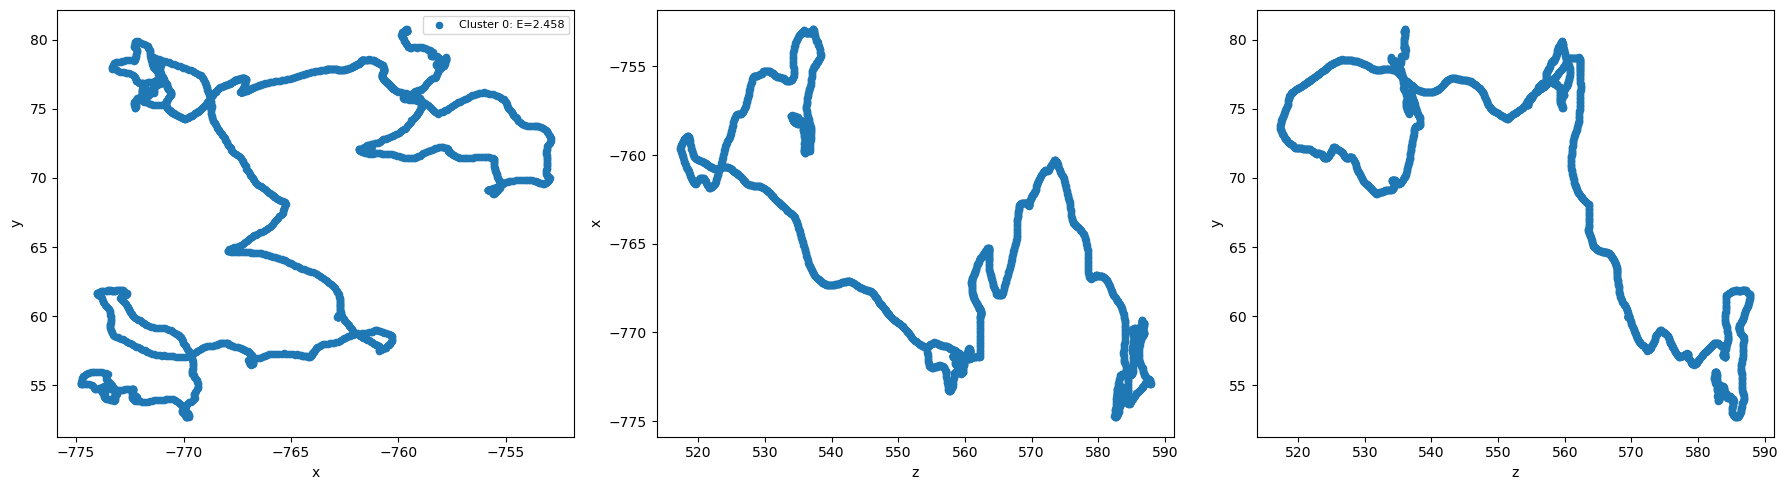

In [450]:
event_list = df_hits_epem['event_id'].unique()
ev_to_check = event_list[10]
pl.plot_clusters_with_energy(df_hits_epem[df_hits_epem['event_id'] == ev_to_check])

In [451]:
df_hits_epem_HET = sl.filter_HE_cluster(df_hits_epem)

In [452]:
shift_z = df_hits_epem_HET['z'].min()
df_hits_epem_HET['z'] = df_hits_epem_HET['z'] - shift_z

In [453]:
df_hits_epem_HET[df_hits_epem_HET['event_id'] == ev_to_check]

,event_id,x,y,z,time,energy,label,particle_id,hit_id
22755,10,-760.216370,76.401817,1445.912109,0.000342,0.001387,0,2,0
22756,10,-760.229431,76.428711,1446.007324,0.000684,0.000079,0,2,1
22757,10,-760.247437,76.457581,1446.101318,0.001025,0.000349,0,2,2
22758,10,-760.264893,76.487091,1446.195068,0.001367,0.000674,0,2,3
22759,10,-760.282471,76.515617,1446.289062,0.001709,0.000609,0,2,4
...,...,...,...,...,...,...,...,...,...
25043,10,-759.608398,80.604691,1462.240967,0.246512,0.000851,0,1,601
25044,10,-759.603760,80.608963,1462.239746,0.246630,0.000928,0,1,602
25045,10,-759.605286,80.603859,1462.240479,0.246735,0.002386,0,1,603
25046,10,-759.605591,80.603607,1462.237549,0.246807,0.003304,0,1,604


In [454]:
p1, p2 = MCtp.find_tree_extremities(df_hits_epem_HET[df_hits_epem_HET['event_id'] == ev_to_check])

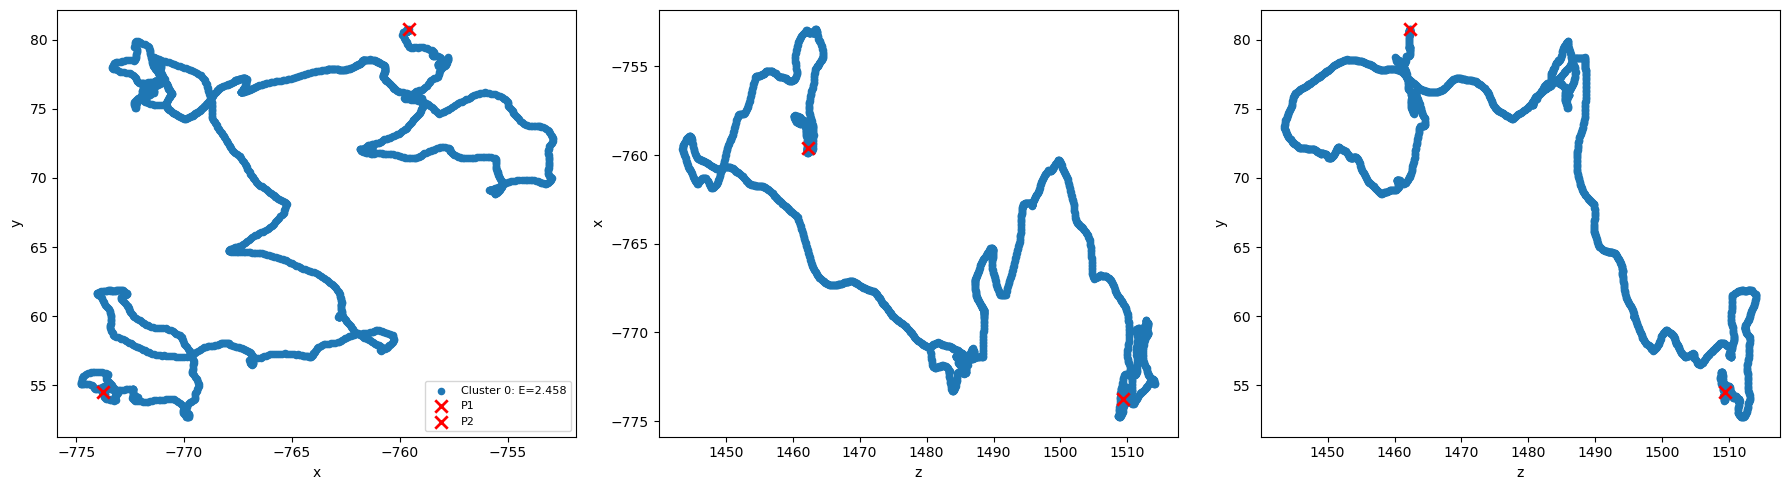

In [455]:
pl.plot_clusters_with_energy(df_hits_epem_HET[df_hits_epem_HET['event_id'] == ev_to_check], (p1,p2))

In [456]:
wval = 0.000015#w-value from https://journals.aps.org/pra/abstract/10.1103/PhysRevA.12.1771
df_hits_epem_HET = af.compute_el_ion_pairs(df_hits_epem_HET,wval)

# 0nubb ions diff analysis

In [457]:
extremity_df_onubb = MCtp.build_extremities_df(df_hits_epem_HET)

Processing events: 100%|██████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.69it/s]


In [458]:
true_p1 = extremity_df_onubb.loc[extremity_df_onubb['event_id']==ev_to_check, 'p1'].iloc[0]
true_p2 = extremity_df_onubb.loc[extremity_df_onubb['event_id']==ev_to_check, 'p2'].iloc[0]

In [459]:
il.reload(MCtp)
df_counts = MCtp.build_3d_counts_df(df_hits_epem_HET[df_hits_epem_HET['event_id'] == ev_to_check], diff_coeff_T, diff_coeff_L*10**3)

11372400


In [460]:
df_counts

,X,Y,Z,Q
0,-760.257288,76.365009,1443.598642,33
1,-760.257288,76.365009,1445.561499,34
2,-760.257288,76.365009,1447.524356,31
3,-760.257288,76.365009,1449.487213,4
4,-760.257288,76.365009,1441.635784,10
...,...,...,...,...
10229,-759.657288,80.565009,1459.301499,609
10230,-759.657288,80.565009,1457.338642,148
10231,-759.657288,80.565009,1467.152928,9
10232,-759.657288,80.565009,1465.190071,139


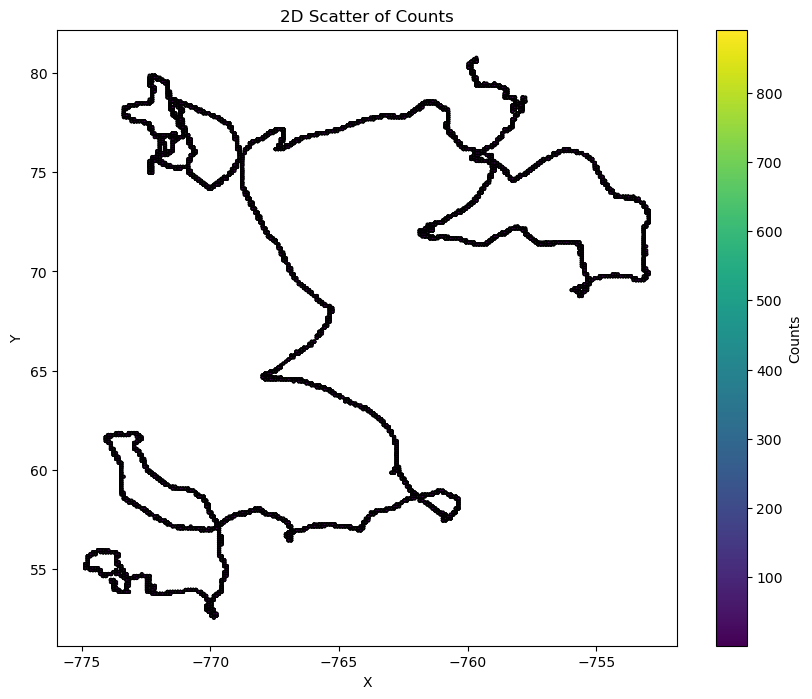

In [461]:
plt.figure(figsize=(10,8))
scatter = plt.scatter(df_counts['X'], df_counts['Y'], c=df_counts['Q'],
                      cmap='viridis', s=4, edgecolor='k')  # s is marker size

plt.colorbar(scatter, label='Counts')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Scatter of Counts')
plt.show()

In [462]:
Q_thr = 10

In [463]:
dx,dy,dz = tf.compute_min_axis_spacing(df_counts)
df_counts['X'] = df_counts['X']/dx
df_counts['Y'] = df_counts['Y']/dy
df_counts['Z'] = df_counts['Z']/dz



In [464]:
true_p1= true_p1 / np.array([dx, dy, dz])
true_p2= true_p2 / np.array([dx, dy, dz])

In [465]:
plf.plot_3D_points_with_Q(df_counts, title='Original Track', true_points = (true_p1,true_p2))

In [470]:
df_counts_thr = df_counts[df_counts['Q'] > Q_thr ]

### Version 1

In [473]:
plf.plot_3D_points_with_Q(df_counts_thr, true_points = (true_p1,true_p2) ,title='Track with isolated point removed')

In [ ]:
il.reload(tf)
primary_path, path_length = tf.compute_primary_path(df_counts_thr)

In [ ]:
plf.plot_3D_points_with_Q(df_counts_thr, primary_path, title='Track Thresholded with point removed and primary path')

In [396]:
smootherd_path = tf.reconstruct_path(df_counts_thr, primary_path, 1.5)

In [397]:
plf.plot_3D_points_with_Q(df_counts_thr, smootherd_path, title='Track Thresholded with point removed and smoothed path')

In [398]:
smootherd_path = tf.reconstruct_path(df_counts_thr, smootherd_path, 1.5)

In [399]:
plf.plot_3D_points_with_Q(df_counts_thr, smootherd_path, title='Track Thresholded with point removed and smoothed path 2nd iter')

In [400]:
pt1 = smootherd_path[0]
pt2 = smootherd_path[-1]

In [401]:
plf.plot_3D_points_with_Q(df_counts_thr,smootherd_path,(pt1,pt2),true_points = (true_p1,true_p2), ellipse_size=(6,9), title='Track Thresholded with point removed and smoothed path mean filtered with blobs')


In [402]:
df_ori_track_scaled = df_hits_epem_HET[df_hits_epem_HET['event_id'] == ev_to_check]
df_ori_track_scaled['x'] = df_ori_track_scaled['x']/dx
df_ori_track_scaled['y'] = df_ori_track_scaled['y']/dy
df_ori_track_scaled['z'] = df_ori_track_scaled['z']/dz

/var/folders/pd/hx80lcqj1szc4vdz3mbmmv680000gn/T/ipykernel_31279/998659465.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/pd/hx80lcqj1szc4vdz3mbmmv680000gn/T/ipykernel_31279/998659465.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/pd/hx80lcqj1szc4vdz3mbmmv680000gn/T/ipykernel_31279/998659465.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [403]:
plf.plot_3D_points_with_ori_track(df_counts,df_ori_track_scaled)

In [404]:
il.reload(MCtp)
Q1 = MCtp.sum_Q_in_ellipsoid(pt1, df_counts, ellipse_size=(2,7))
Q2 = MCtp.sum_Q_in_ellipsoid(pt2, df_counts, ellipse_size=(2,7))

### Version 2

In [432]:
plf.plot_3D_points_with_Q(df_counts, title='Original Track', true_points = (true_p1, true_p2))

In [433]:
#df_counts_thr = tf.remove_isolated_points(df_counts_thr)

In [434]:
il.reload(tf)
skeleton_nodes, skeleton_edges = tf.skeletonize_point_cloud_from_dfV2(df_counts_thr, distance_threshold=1.7, min_degree=2)

In [435]:
plf.plot_3D_points_with_Q(df_counts_thr, skeleton_nodes, title='Track Thresholded with skeleton')

In [436]:
smootherd_path = tf.reconstruct_path(df_counts_thr, skeleton_nodes, 1.5)

In [437]:
plf.plot_3D_points_with_Q(df_counts_thr, smootherd_path[0::8], title='Track Thresholded with smoothed skeleton')

In [438]:
sorted_smootherd_path = tf.order_points_longest_greedy(smootherd_path[0::8])

In [439]:
plf.plot_3D_points_with_Q(df_counts_thr, sorted_smootherd_path, title='Track Thresholded with smoothed skeleton')

In [440]:
smootherd_path = tf.reconstruct_path(df_counts_thr, sorted_smootherd_path, 2.5)

In [441]:
sorted_smootherd_path = tf.order_points_longest_greedy(smootherd_path)

In [442]:
plf.plot_3D_points_with_Q(df_counts_thr, sorted_smootherd_path, title='Track Thresholded with double smoothed skeleton')

In [443]:
pt1 = smootherd_path[0]
pt2 = smootherd_path[-1]

In [444]:
plf.plot_3D_points_with_Q(df_counts_thr,smootherd_path,(pt1,pt2),true_points = (true_p1,true_p2), ellipse_size=(2,7), title='Track Thresholded with double smoothed skeleton with blobs')


### Version 3

In [418]:
il.reload(tf)
il.reload(MCtp)

<module 'MC_topology' from '/Users/samuele/Documents/Postdoc/ITACA/GXe_TrackAnalysis/../0nubbdata_LXe_Analysis/src/MC_topology.py'>

In [419]:
ev_to_check=1

In [420]:
true_p1 = extremity_df_onubb.loc[extremity_df_onubb['event_id']==ev_to_check, 'p1'].iloc[0]
true_p2 = extremity_df_onubb.loc[extremity_df_onubb['event_id']==ev_to_check, 'p2'].iloc[0]

In [421]:
df_event = df_hits_epem_HET[df_hits_epem_HET['event_id'] == ev_to_check]

In [422]:
hist_bins, edges_x, edges_y = MCtp.build_2d_bool_hist(df_event, diff_coeff_T,5)

In [423]:
skel = tf.skeleton_voxel_coordinates2D(hist_bins, edges_x, edges_y)

In [424]:
df_counts = MCtp.build_3d_counts_df(df_hits_epem_HET[df_hits_epem_HET['event_id'] == ev_to_check], diff_coeff_T, diff_coeff_L*10**3)

15463188


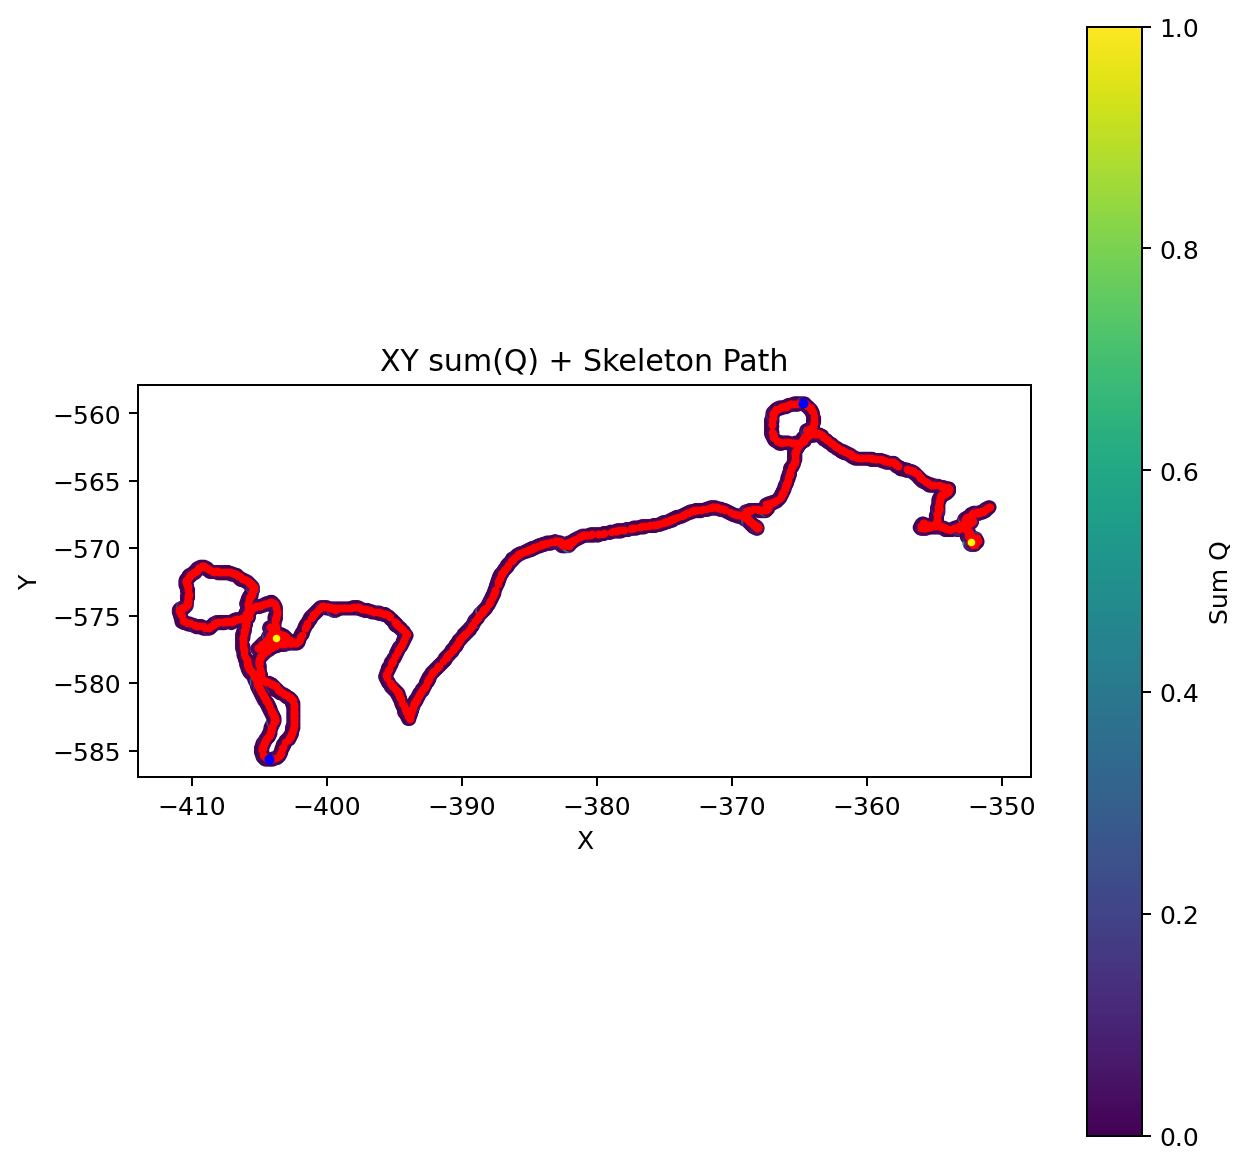

In [431]:
# --- 1. Sum Q for each (X,Y) ---
df_xy = df_counts.groupby(["X","Y"])["Q"].sum().reset_index()

# Extract arrays
xs = df_xy["X"].values
ys = df_xy["Y"].values
qs = df_xy["Q"].values

# --- 2. Plot ---
plt.figure(figsize=(8,8),dpi=180)

# scatter of XY with color = sum(Q)
plt.scatter(xs, ys, c=qs, s=20, cmap="viridis")

# overlay skeleton points
plt.scatter(skel[:,0], skel[:,1], color="red", s=4)


plt.scatter(true_p1[0], true_p1[1], color="yellow", s=4)
plt.scatter(true_p2[0], true_p2[1], color="yellow", s=4)

# First point
plt.scatter(skel[0,0], skel[0,1], color="blue", s=9)
plt.scatter(skel[-1,0], skel[-1,1], color="blue", s=9)


plt.xlabel("X")
plt.ylabel("Y")
plt.title("XY sum(Q) + Skeleton Path")
plt.colorbar(label="Sum Q")
plt.gca().set_aspect("equal", "box")

plt.show()